In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

In [2]:
def letterToIndex(letter):
    return amino_acids.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, len(amino_acids))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, len(amino_acids))
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.squeeze()

In [3]:
amino_acids = 'XWGSAELQDMPFTRIHVNCY_K'

In [4]:
fName = 'embedding_siamese_test.csv'

pos_test = np.genfromtxt(fName,delimiter=',',dtype=float)
pos_test = pos_test.reshape(pos_test.shape[0],15,pos_test.shape[1] // 15)

motifs_test = (np.genfromtxt('data_filtered/motifs_test.csv',dtype='U'))
motifxFamMatrix_test = np.genfromtxt('data_filtered/motifxFamMatrix_test.csv',delimiter=',',dtype=int)
target_test = torch.tensor(motifxFamMatrix_test).float()

fams = (np.genfromtxt('data_filtered/fams.csv',dtype='U'))

features_test = [] 
for mIdx, motif in enumerate(motifs_test):
    motif_tensor = lineToTensor(motif).float() ########################
    coords = torch.tensor(pos_test[mIdx])
    feature = torch.cat((motif_tensor.float(), coords.float()), 1)
    features_test.append(torch.tensor(feature.detach().numpy())) ########################
features_test = torch.stack(features_test)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

HIDDEN_DIM_0 = 64
HIDDEN_DIM_1 = 32
OUT_DIM = len(fams)

class Model(nn.Module):
    def __init__(self, batch_size, motifDrpt, coordDrpt, catDrpt):
        super(Model, self).__init__()
        
        self.motif_conv1 = nn.Conv1d(in_channels=len(amino_acids), out_channels=HIDDEN_DIM_0, kernel_size=1, stride=1)
        self.motif_conv2 = nn.Conv1d(in_channels=HIDDEN_DIM_0, out_channels=HIDDEN_DIM_1, kernel_size=2, stride=1)
        self.motif_conv3 = nn.Conv1d(in_channels=HIDDEN_DIM_1, out_channels=HIDDEN_DIM_1, kernel_size=3, stride=1)
        self.motif_fc1 = nn.Linear(384, HIDDEN_DIM_0) # 192 #768
        self.motif_fc2 = nn.Linear(HIDDEN_DIM_0, HIDDEN_DIM_0)
        
                
        # coords CNN 
        self.conv1 = nn.Conv1d(in_channels=pos_test.shape[2], out_channels=HIDDEN_DIM_0, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=HIDDEN_DIM_0, out_channels=HIDDEN_DIM_1, kernel_size=2, stride=1)
        self.conv3 = nn.Conv1d(in_channels=HIDDEN_DIM_1, out_channels=HIDDEN_DIM_1, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(384, HIDDEN_DIM_0) # 192 #768            
        self.fc2 = nn.Linear(HIDDEN_DIM_0, HIDDEN_DIM_0)

        # concat
        self.cat_fc1 = nn.Linear(HIDDEN_DIM_0 + HIDDEN_DIM_0, HIDDEN_DIM_0)
        self.cat_fc2 = nn.Linear(HIDDEN_DIM_0, HIDDEN_DIM_0)
        self.cat_bn2 = nn.BatchNorm1d(HIDDEN_DIM_0)
        self.cat_out = nn.Linear(HIDDEN_DIM_0, OUT_DIM)
        
        self.output = nn.Linear(HIDDEN_DIM_0, OUT_DIM)
        self.sigmoid = nn.Sigmoid()
        
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(HIDDEN_DIM_0)
        self.bn1 = nn.BatchNorm1d(HIDDEN_DIM_1)
        
        myMotifDrpt = motifDrpt
        myCoordDrpt = coordDrpt
        myCatDrpt = catDrpt
        
        self.dropout_motifs = nn.Dropout(p=myMotifDrpt)
        self.dropout_coords = nn.Dropout(p=myCoordDrpt)
        self.dropout_cat = nn.Dropout(p=myCatDrpt)

    def forward(self, sentence, coords, version='seqCoord'):
        
#         print(sentence.shape, coords.shape)

        # motif CNN
        sentence = sentence.transpose(1,2).float()

        motif_conv1 = self.motif_conv1( sentence ) 
        motif_conv1 = self.relu( motif_conv1 )
        motif_conv1 = self.dropout_motifs( motif_conv1 )
        motif_conv2 = self.motif_conv2( motif_conv1 ) 
        motif_conv2 = self.relu( motif_conv2 )
        motif_conv2 = self.dropout_motifs( motif_conv2 )
        motif_conv3 = self.motif_conv3( motif_conv2 ) 
        motif_conv3 = self.relu( motif_conv3 )
        motif_conv3 = self.dropout_motifs( motif_conv3 )
        motif_conv3 = motif_conv3.reshape(motif_conv3.shape[0],motif_conv3.shape[1]*motif_conv3.shape[2])
                
        motif_fc1 = self.motif_fc1( motif_conv3 )
        motif_fc1 = self.bn0( motif_fc1 )
        motif_fc1 = self.relu( motif_fc1 )
        motif_fc1 = self.dropout_motifs( motif_fc1 )
        
        motif_fc2 = self.motif_fc2( motif_fc1 )
        motif_fc2 = self.bn0( motif_fc2 )
        motif_fc2 = self.relu( motif_fc2 )
        motif_out = self.dropout_motifs( motif_fc2 )
        
        # coords CNN 
        coords = coords.transpose(1,2).float()

#         print (coords.shape)   
        conv1 = self.conv1( coords ) 
        conv1 = self.relu( conv1 )
        conv1 = self.dropout_coords( conv1 )
#         print (conv1.shape)  
        conv2 = self.conv2( conv1 ) 
        conv2 = self.relu( conv2 )
        conv2 = self.dropout_coords( conv2 )
#         print (conv2.shape) 
        conv3 = self.conv3( conv2 ) 
        conv3 = self.relu( conv3 )
        conv3 = self.dropout_coords( conv3 )
#         print(conv3.shape)
        conv3 = conv3.reshape(conv3.shape[0],conv3.shape[1]*conv3.shape[2])
        
#         print(conv3.shape)

        fc1 = self.fc1( conv3 )
        fc1 = self.bn0( fc1 )
        fc1 = self.relu( fc1 )
        fc1 = self.dropout_coords( fc1 )
#         print(fc1.shape)
#         print("==============")
        
        fc1 = self.fc2( fc1 )
        fc1 = self.bn0( fc1 )
        fc1 = self.relu( fc1 )
        coords_out = self.dropout_coords( fc1 )
        

        # concat layers
        if version=='seqCoord':
            cat_init = torch.cat((motif_out, coords_out), 1)
        else: # motif-only version
            cat_init = torch.cat((motif_out, motif_out), 1) 
            
        cat_fc1 = self.cat_fc1(cat_init)
        cat_fc1 = self.bn0(cat_fc1)
        cat_fc1 = self.relu(cat_fc1)
        cat_fc1 = self.dropout_cat(cat_fc1)
        
#         cat_fc2 = self.cat_fc2(cat_fc1)
#         cat_fc2 = self.bn0(cat_fc2)
#         cat_fc2 = self.relu(cat_fc2)
#         cat_fc2 = self.dropout(cat_fc2)
        
        cat_out = self.cat_out( cat_fc1 )

        cat_sigmoid = self.sigmoid(cat_out)
   
        return cat_sigmoid

In [9]:
def eval_model(model, thresh=0.5):
    
    model.eval()
        
    BATCH_SIZE = len(motifs_test)
    
    train = data_utils.TensorDataset(features_test, target_test)
    train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        sentence = inputs[:,:,:len(amino_acids)]
        coords = inputs[:,:,len(amino_acids):]
        outputs = model(sentence=sentence,coords=coords)   # Set model to evaluate mode

        accuracy = 0
        totTrues = 0
        for i,out in enumerate(outputs):
            pred = np.where(out.cpu().detach().numpy() > thresh)[0]
            if len(pred)<1: 
                pred = [np.argmax(out.cpu().detach().numpy())]
            true = np.where(labels.data.cpu()[i]==1)[0]
            totTrues += len(true)
            accuracy += len(pred)

        y_score = outputs.cpu().detach().numpy()
        y_test = np.array(labels.cpu())
        
        return (accuracy/BATCH_SIZE, y_score, y_test)

In [12]:
device = torch.device("cpu")

BS = len(motifs_test)

totAcc = []
totY_score = []
totY_test = []

motifDrpt = False
coordDrpt = False
catDrpt = False

model = Model(BS,motifDrpt,coordDrpt,catDrpt) 
model = model.to(device)


model.load_state_dict(torch.load('model_EMBER'))
(accuracy, y_score, y_test) = eval_model(model, thresh=0.5)

totAcc.append(accuracy)
totY_score.extend(y_score)
totY_test.extend(y_test)

['APPEKAESEVAPGAP' 'RNLLEDDSDEEEDFF' 'SSAVRLRSSVPGVRL' 'SYCEPPSYRPMHHED'
 'SSVTVTRSYRSVGGS' 'AGSTDENTDSEEHQE' 'QSRSRSSSRERSRSR' 'PEALHYDYIDVEMSA'
 'RIMEVVGTPSPEVLA' 'RSRAIHSSDEGEDQA']
tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.]]) [[0.37980825 0.2824637  0.30900258 ... 0.4872994  0.31482822 0.256318  ]
 [0.39746717 0.30027637 0.3133947  ... 0.4704829  0.3359055  0.24819739]
 [0.42152056 0.40584108 0.3955765  ... 0.42667282 0.39732167 0.33458596]
 ...
 [0.39189276 0.37170568 0.3599765  ... 0.39236832 0.3489709  0.3016923 ]
 [0.38203073 0.33099586 0.36024466 ... 0.45149523 0.3306628  0.26732033]
 [0.41398215 0.38514706 0.29665822 ... 0.3879803  0.40062904 0.25170338]]
accuracy: 0.77068345323741 857 1112


In [78]:
import numpy

y_test = numpy.array(totY_test)
y_score = numpy.array(totY_score)

for i in range(len(y_test)):
    trueIdc = numpy.where(y_test[i]==1)[0]
    predIdc = numpy.where(y_score[i]>0.5)[0]
    if len(predIdc)<1:
        predIdc = [numpy.argmax(y_score[i])]
        
    trueLab = fams[trueIdc]
    predLab = fams[predIdc]
y_test.shape

(857, 8)

In [51]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))



average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
average_precision["macro"] = average_precision_score(y_test, y_score,
                                                     average="macro")

print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.159
Average precision score, micro-averaged over all classes: 0.180


In [35]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

FAM_IDC = [x for x in range(len(fams))]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

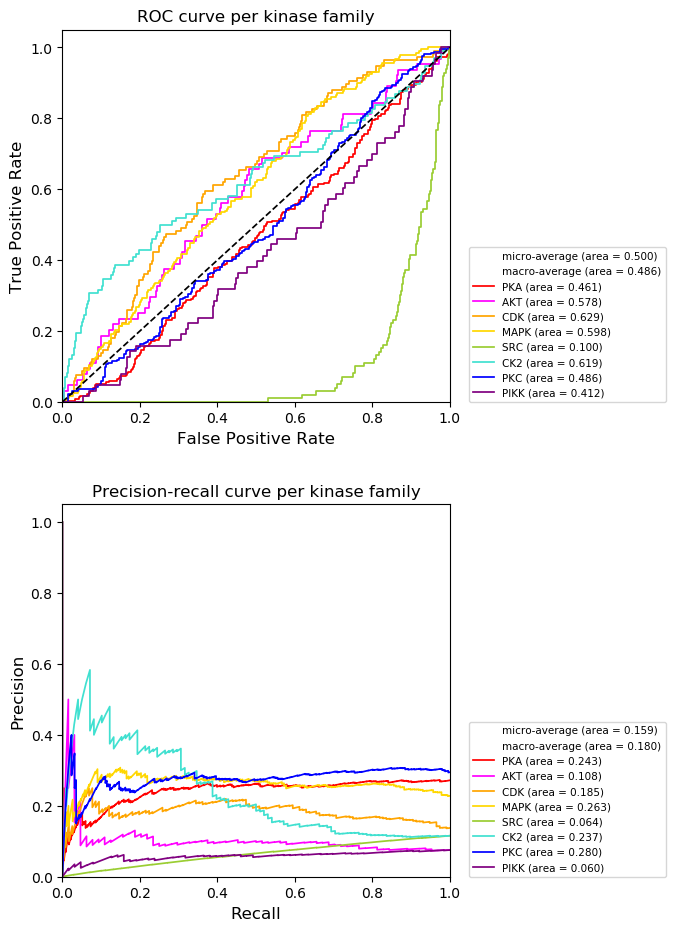

In [29]:
from itertools import cycle
# colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red','turquoise','brown','tomato',
#                'purple','pink','orchid']) 
# colors = cycle(['brown','red','tomato','orange','gold','#E3CF57','yellowgreen','green','turquoise','blue','navy','purple','orchid','pink',
#                 'magenta']) 
# colors = cycle(['red','orange','#E3CF57','green','blue', 'purple']) 


colors = cycle(['red','magenta','orange', 'gold','yellowgreen',
                'turquoise', 'blue', 'purple']) 

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,11))
lw = 1.25

ax1.plot(fpr["micro"], tpr["micro"],label='micro-average (area = {0:0.3f})'''.format(roc_auc["micro"]), 
         color='white', linestyle=':', linewidth=lw)
ax1.plot(fpr["macro"], tpr["macro"], label='macro-average (area = {0:0.3f})'''.format(roc_auc["macro"]),
         color='white', linestyle=':', linewidth=lw)

for i, color in zip( range( len(fams) ), colors):
    fam = fams[i]
#     print(color)
    ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.3f})'
             ''.format(fam, roc_auc[i]))

fig.subplots_adjust(hspace=.275)
ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.set_xlabel('False Positive Rate',fontsize=12) #20)
ax1.set_ylabel('True Positive Rate',fontsize=12) #20)
ax1.set_title('ROC curve per kinase family',fontsize=12) #=20)
ax1.legend(loc=(1.05, .0), fontsize=7.5) #12.5)

# colors = cycle(['magenta','red','orange', 'gold', '#E3CF57','yellowgreen','green','turquoise','blue','purple','orchid','pink',
#                 'magenta']) 

colors = cycle(['red','magenta','orange', 'gold','yellowgreen',
                'turquoise', 'blue', 'purple']) 

lines = []
labels = []


l, = ax2.plot(recall["micro"], precision["micro"], color='white', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'
              ''.format(average_precision["micro"]))
l, = ax2.plot(recall["micro"], precision["micro"], color='white', lw=1.5,linestyle=':')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'
              ''.format(average_precision["macro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=lw)
#     print(color)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.3f})'
                  ''.format(fclass, average_precision[i]))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_xlabel('Recall',fontsize=12) #20)
ax2.set_ylabel('Precision',fontsize=12) #20)
ax2.set_title('Precision-recall curve per kinase family',fontsize=12) #=20)
ax2.legend(lines, labels, loc=(1.05, .0), fontsize=7.5) #12.5)

# plt.savefig(figFile + run + "_roc_prc", bbox_inches='tight')
plt.show()